In [ ]:
import numpy as np
import pandas as pd
import pymc as pm

### ARIMA with PyMC

### AR model

In [ ]:
try:
    df = pd.read_csv("../data/AirPassengers.csv", parse_dates=["Month"])
except FileNotFoundError:
    df = pm.get_data("AirPassengers.csv", parse_dates=["Month"])

In [ ]:
df.shape

(144, 2)

In [ ]:
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


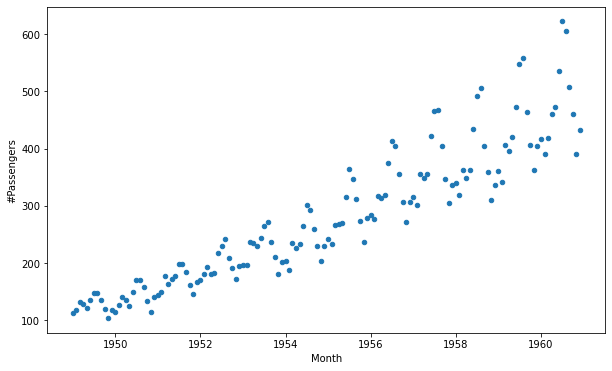

In [ ]:
df.plot(x='Month', y= '#Passengers', kind='scatter', figsize=(10, 6));

In [ ]:
# def ar1(phi=0.9, n=1000, init=0):
#     ts = [init]
#     error = np.random.randn(n)
#     for period in range(n):
#         ts.append(error[period] + phi*ts[-1])
#     return pd.Series(ts[1:], index=range(n))

# def ar2(phi1=0.9, phi2=-0.8, n=1000, init=0):
#     ts = [init, init]
#     error = np.random.randn(n)
#     for period in range(2,n):
#         ts.append(error[period] + phi1*ts[-1] + phi2*ts[-2])
#     return pd.Series(ts[1:], index=range(1,n))

In [ ]:
# Y(t) = mu + phi*Y(t-1) + err


with pm.Model() as ar1:
    Y = at.vector('Y')
    phi = pm.Normal('phi', 0, 1.0)
    mu = pm.Normal('mu', 0, 1.0)
    err = pm.Normal('err', 0, 1.0)
    sigma = pm.HalfNormal('sigma', 1.0)
    
    y_next, updates = aesara.scan(fn=lambda y: mu + phi*y + err,
                         sequences=Y)

    compute_ar1 = aesara.function(inputs=[Y, mu, phi, err], 
                                   outputs=y_next)
    
    pm.Potential("like", pm.Normal.dist(0, sigma=sigma).logp(y_next))

UnusedInputError: aesara.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: mu.
To make this error into a warning, you can pass the parameter on_unused_input='warn' to aesara.function. To disable it completely, use on_unused_input='ignore'.

In [ ]:
mu = at.scalar('mu')
phi = at.scalar('phi')
err = at.scalar('err')
Y = at.vector('Y')
y_next, updates = aesara.scan(fn=lambda y: mu + phi*y + err,
                         sequences=Y)

compute_ar1 = aesara.function(inputs=[Y, mu, phi, err], 
                           outputs=y_next)

# Test values
y = np.zeros((2), dtype=aesara.config.floatX)
y = df["#Passengers"].values

compute_ar1(y, 1, 1, 0.1)

array([113.1, 119.1, 133.1, 130.1, 122.1, 136.1, 149.1, 149.1, 137.1,
       120.1, 105.1, 119.1, 116.1, 127.1, 142.1, 136.1, 126.1, 150.1,
       171.1, 171.1, 159.1, 134.1, 115.1, 141.1, 146.1, 151.1, 179.1,
       164.1, 173.1, 179.1, 200.1, 200.1, 185.1, 163.1, 147.1, 167.1,
       172.1, 181.1, 194.1, 182.1, 184.1, 219.1, 231.1, 243.1, 210.1,
       192.1, 173.1, 195.1, 197.1, 197.1, 237.1, 236.1, 230.1, 244.1,
       265.1, 273.1, 238.1, 212.1, 181.1, 202.1, 205.1, 189.1, 236.1,
       228.1, 235.1, 265.1, 303.1, 294.1, 260.1, 230.1, 204.1, 230.1,
       243.1, 234.1, 268.1, 270.1, 271.1, 316.1, 365.1, 348.1, 313.1,
       275.1, 238.1, 279.1, 285.1, 278.1, 318.1, 314.1, 319.1, 375.1,
       414.1, 406.1, 356.1, 307.1, 272.1, 307.1, 316.1, 302.1, 357.1,
       349.1, 356.1, 423.1, 466.1, 468.1, 405.1, 348.1, 306.1, 337.1,
       341.1, 319.1, 363.1, 349.1, 364.1, 436.1, 492.1, 506.1, 405.1,
       360.1, 311.1, 338.1, 361.1, 343.1, 407.1, 397.1, 421.1, 473.1,
       549.1, 560.1,

In [ ]:
y.shape

(2,)

In [ ]:
.shape

(144,)

In [ ]:
import numpy as np
import arviz as az
import pymc as pm

In [ ]:
# data = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)
data = df["#Passengers"].values
y = aesara.shared(data)

with pm.Model() as arma_model:
    sigma = pm.HalfNormal("sigma", 5.0)
    theta = pm.Normal("theta", 0.0, sigma=1.0)
    phi = pm.Normal("phi", 0.0, sigma=2.0)
    mu = pm.Normal("mu", 0.0, sigma=10.0)

    err0 = y[0] - (mu + phi * mu)

    def calc_next(last_y, this_y, err, mu, phi, theta):
        nu_t = mu + phi * last_y + theta * err
        return this_y - nu_t

    err, _ = aesara.scan(
        fn=calc_next,
        sequences=dict(input=y, taps=[-1, 0]),
#         sequences=[y],
        outputs_info=[err0],
        non_sequences=[mu, phi, theta],
    )

    _ = pm.logp(pm.Potential("like", pm.Normal.dist(0, sigma=sigma)), err)

In [ ]:
with arma_model:
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.99)

/home/danph/Repos/win_ssd/oss/pymc/pymc/aesaraf.py:378: UserWarning: No value variable found for like; the random variable will not be replaced.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, phi, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

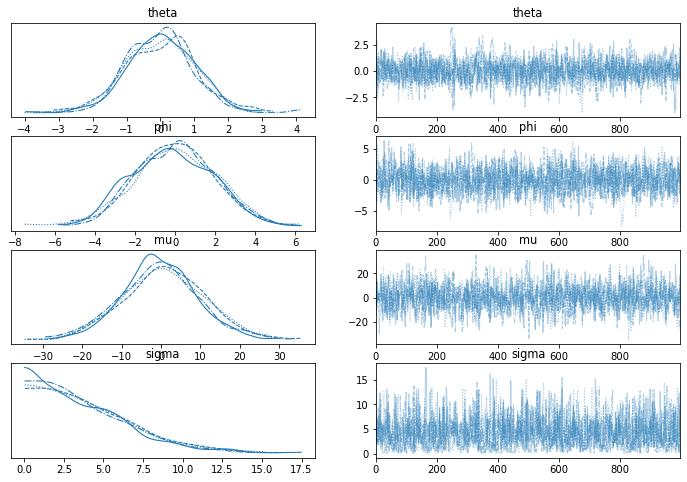

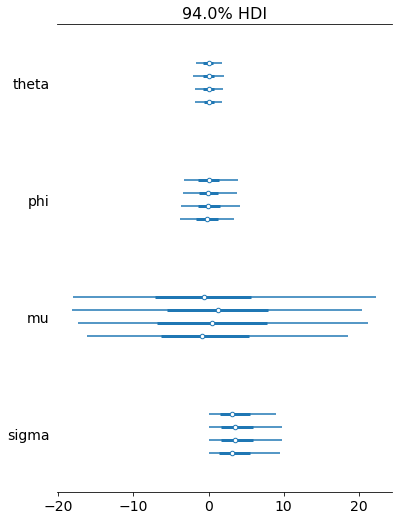

In [ ]:
az.plot_trace(trace)
az.plot_forest(trace)

In [ ]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (chain, draw) float64 0.01489 -0.0515 -0.03328 ... -0.4688 0.3368
    phi      (chain, draw) float64 -3.014 -3.262 1.163 ... 1.054 0.8765 0.7952
    mu       (chain, draw) float64 -3.72 -4.312 5.971 ... -25.44 -25.61 -15.55
    sigma    (chain, draw) float64 2.907 2.772 6.904 6.089 ... 6.402 6.101 4.073
Attributes:
    created_at:                 2022-05-14T07:38:08.228481
    arviz_version:              0.12.0
    inference_library:          pymc
    inference_library_version:  4.0.0b6
    sampling_time:              59.06132912635803
    tuning_steps:               1000

In [ ]:
trace

Inference data with groups:
	> posterior
	> sample_stats